In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
stopword_list = nltk.corpus.stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import seaborn as sns
from collections import Counter
import datetime
from tqdm import tqdm

# Default parameters for Matplotlib
# plt.rcParams["figure.figsize"] = (16,8)
# plt.rcParams["figure.dpi"] = 300
# plt.rcParams['axes.grid'] = True 
# plt.rcParams.update({'font.size': 20})
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fedebotu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/fedebotu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/fedebotu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fedebotu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1. Cleaning the Twitter Data

In [29]:
# Read in and preview 'tesla_data.csv'

tweets = pd.read_csv('data/tesla_data.csv')
tweets.head()

,id,date,tweet,retweets_count
0,1344433053481910277,2020-12-31,"Di penghujung 2020, $tsla 695! Skg market cap...",1
1,1344432737491542016,2020-12-31,I wish I would’ve bought more when I did 😫 #ts...,0
2,1344432169037553668,2020-12-31,@BrentBrickman @ByronArant Boy i tweeted somet...,0
3,1344431812781727744,2020-12-31,$TSLA will close 2020: #TSLA #Tesla #teslasto...,0
4,1344431770519949314,2020-12-31,Tesla Shares Rise on Big Q4 Delivery Expectati...,0


In [30]:
# Convert date_time column into datetime stamp
tweets.date = pd.to_datetime(tweets.date)

### 2. Clean & Tokenize Tweets

In [31]:
def cleaner(dataframe):
    # Add whitespace to the end of every tweet
    dataframe['cleaned_tweet'] = dataframe.tweet.map(lambda x: x + " ") 
    # Remove http links
    dataframe.cleaned_tweet = dataframe.cleaned_tweet.map(lambda x: re.sub(r'http.*', '', x))
    # Remove special characters and numbers
    dataframe.cleaned_tweet = dataframe.cleaned_tweet.map(lambda x: re.sub(r"[^a-zA-Z#]", ' ', x))
    # Lowercase all tweets
    dataframe.cleaned_tweet = dataframe.cleaned_tweet.map(lambda x: x.lower())
    #Tokenize tweets and remove stop words
    stopword_list = stopwords.words('english')
    for i in tqdm(range(len(dataframe.cleaned_tweet))):
        tokens = word_tokenize(dataframe.cleaned_tweet[i])
        clean_tokens = [w for w in tokens if w not in stopword_list]
        dataframe.cleaned_tweet[i] = clean_tokens

In [32]:
cleaner(tweets)
tweets.head()

  0%|          | 0/89882 [00:00<?, ?it/s]<ipython-input-31-88a107c10dc8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.cleaned_tweet[i] = clean_tokens
100%|██████████| 89882/89882 [03:17<00:00, 455.76it/s]


,id,date,tweet,retweets_count,cleaned_tweet
0,1344433053481910277,2020-12-31,"Di penghujung 2020, $tsla 695! Skg market cap...",1,"[di, penghujung, tsla, skg, market, capnya, b,..."
1,1344432737491542016,2020-12-31,I wish I would’ve bought more when I did 😫 #ts...,0,"[wish, would, bought, #, tsla, #, tesla, #, el..."
2,1344432169037553668,2020-12-31,@BrentBrickman @ByronArant Boy i tweeted somet...,0,"[brentbrickman, byronarant, boy, tweeted, some..."
3,1344431812781727744,2020-12-31,$TSLA will close 2020: #TSLA #Tesla #teslasto...,0,"[tsla, close, #, tsla, #, tesla, #, teslastock..."
4,1344431770519949314,2020-12-31,Tesla Shares Rise on Big Q4 Delivery Expectati...,0,"[tesla, shares, rise, big, q, delivery, expect..."


### 3. Lemmatize Tweets

In [33]:
tweets.cleaned_tweet[0]

['di',
 'penghujung',
 'tsla',
 'skg',
 'market',
 'capnya',
 'b',
 'jgn',
 'kaget',
 'skg',
 'ada',
 'nama',
 'teslanaires',
 'panggilan',
 'utk',
 'org',
 'yg',
 'invest',
 'di',
 'stoknya',
 'tesla',
 'dan',
 'skg',
 'nilai',
 'stoknya',
 'sdh',
 'lbh',
 'dr',
 'setidaknya',
 'jt',
 'rp']

In [34]:
def tweet_lemmatizer(tweets):
    
    for i in tqdm(range(len(tweets))):
        # Pos-tag each word in tweet
        for word in [tweets[i]]:
            pos_tag_list = nltk.pos_tag(word)
        # Convert pos-tag to be wordnet compliant
        wordnet_tags = []
        for j in pos_tag_list:
            # Adjective
            if j[1].startswith('J'):
                wordnet_tags.append(wordnet.ADJ)
            # Noun
            elif j[1].startswith('N'):
                wordnet_tags.append(wordnet.NOUN)
            # Adverb
            elif j[1].startswith('R'):
                wordnet_tags.append(wordnet.ADV)
            # Verb
            elif j[1].startswith('V'):
                wordnet_tags.append(wordnet.VERB)
            # Default to noun
            else:
                wordnet_tags.append(wordnet.NOUN)
        # Lemmatize each word in tweet
        lem_words = []
        for k in range(len(tweets[i])):
            lem_words.append(lemmatizer.lemmatize(tweets[i][k], pos=wordnet_tags[k]))
        lem_tweet = ' '.join(lem_words)
        tweets[i] = lem_tweet

In [35]:
tweet_lemmatizer(tweets.cleaned_tweet)
tweets

  0%|          | 0/89882 [00:00<?, ?it/s]<ipython-input-34-2789e7e6f40e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets[i] = lem_tweet
100%|██████████| 89882/89882 [04:34<00:00, 327.65it/s]


,id,date,tweet,retweets_count,cleaned_tweet
0,1344433053481910277,2020-12-31,"Di penghujung 2020, $tsla 695! Skg market cap...",1,di penghujung tsla skg market capnya b jgn kag...
1,1344432737491542016,2020-12-31,I wish I would’ve bought more when I did 😫 #ts...,0,wish would buy # tsla # tesla # elonmusk # stock
2,1344432169037553668,2020-12-31,@BrentBrickman @ByronArant Boy i tweeted somet...,0,brentbrickman byronarant boy tweet something y...
3,1344431812781727744,2020-12-31,$TSLA will close 2020: #TSLA #Tesla #teslasto...,0,tsla close # tsla # tesla # teslastock # stock...
4,1344431770519949314,2020-12-31,Tesla Shares Rise on Big Q4 Delivery Expectati...,0,tesla share rise big q delivery expectation th...
...,...,...,...,...,...
89877,1323748279885193223,2020-11-04,Tesla Inc (TSLA) stock rose by 5.8401%! Curren...,0,tesla inc tsla stock rise currently
89878,1323747925403590663,2020-11-04,Tesla Inc (TSLA) up by 5.8401%! Currently pric...,0,tesla inc tsla currently price # metalsandmarkets
89879,1323746291667664897,2020-11-04,@Sofiaan @elonmusk @Tesla It’s so wild that th...,0,sofiaan elonmusk tesla wild tsla price keep ho...
89880,1323744300518158336,2020-11-04,@stephenpallotta Thanks for the educated input...,0,stephenpallotta thanks educate input new er ev...


In [36]:
tweets.cleaned_tweet[0]

'di penghujung tsla skg market capnya b jgn kaget skg ada nama teslanaires panggilan utk org yg invest di stoknya tesla dan skg nilai stoknya sdh lbh dr setidaknya jt rp'

In [37]:
# Remove the most used but non-informative related words in our case:  'tesla, 'tsla', 'q', and '#'

def final_cleaner(dataframe):
    dataframe.cleaned_tweet = dataframe.cleaned_tweet.map(lambda x: x.replace('#',''))
    dataframe.cleaned_tweet = dataframe.cleaned_tweet.map(lambda x: x.replace('q',''))
    dataframe.cleaned_tweet = dataframe.cleaned_tweet.map(lambda x: x.replace('tesla',''))
    dataframe.cleaned_tweet = dataframe.cleaned_tweet.map(lambda x: x.replace('tsla',''))

In [38]:
final_cleaner(tweets)

In [39]:
# Join all the tweets into a single string
all_words_string = ' '.join([tweet for tweet in tweets.cleaned_tweet])

# Make a list of all the words in the dataframe
all_words_list = all_words_string.split()

### 4. Frequency Analysis

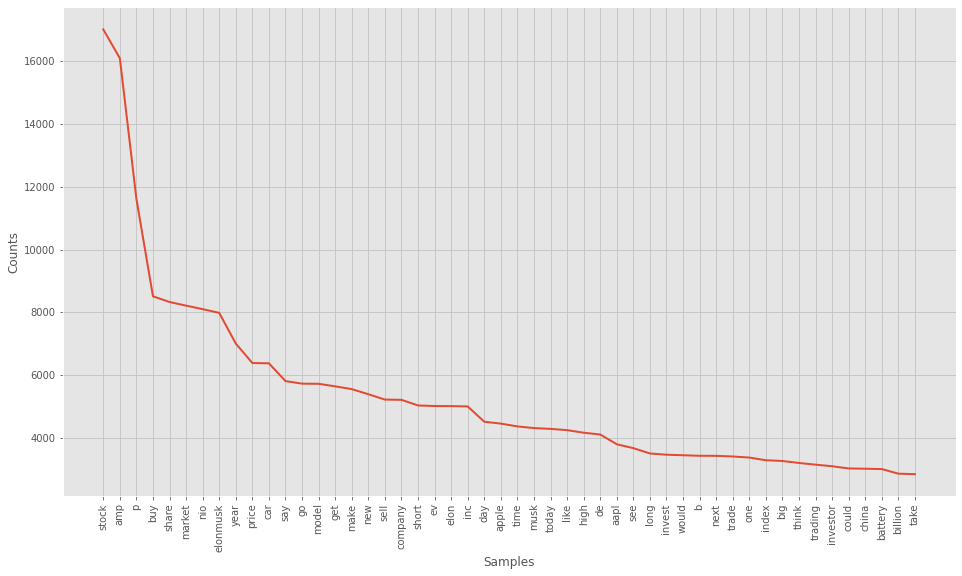

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [50]:
# Plot word frequency distribution of first few words
plt.figure(figsize=(16,9))
plt.xticks(fontsize=10, rotation=90)
freq_dist = nltk.FreqDist(all_words_list)
freq_dist.plot(50, cumulative=False)

In [44]:
# Find the frequency of each word in the dataframe

word_freq = nltk.FreqDist(all_words_list)
freq_df = pd.DataFrame({'Word': list(word_freq.keys()), 'Count': list(word_freq.values())}).sort_values(by=['Count'], ascending=False)
freq_df.head(10)

,Word,Count
29,stock,17009
101,amp,16093
102,p,11612
27,buy,8513
59,share,8332
3,market,8216
463,nio,8105
28,elonmusk,7986
35,year,7009
425,price,6390


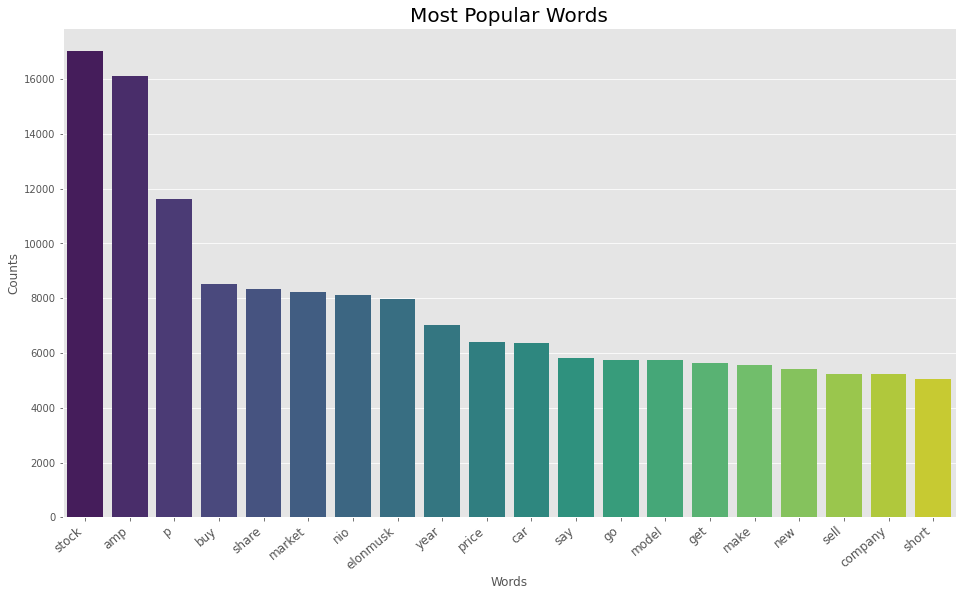

In [51]:
# Plot histogram of most frequent words

freq_df = freq_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,9))
ax = sns.barplot(data=freq_df, x= "Word", y = "Count", palette='viridis')
ax.set_ylabel('Counts', fontsize=12)
ax.set_xlabel('Words', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Most Popular Words", fontsize=20)
# plt.savefig('images/popular_words.pdf', bbox_inches='tight')
plt.show()

## Word Cloud with word frequencies

In [84]:
# Load the image, which will act like a mask. High resolution, black over white .png images will perform better
mask = np.array(Image.open('images/tesla_logo.png'))

# # Applying original colors (WIP)
# logo_color = np.array(Image.open('images/facebook_logo_colored.png'))
# # subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
# logo_color = logo_color[::3, ::3]
# print(np.all(logo_color.shape))
# image_colors = ImageColorGenerator(logo_color)
# wordcloud.recolor(color_func=image_colors) # apply later

Generate Word Cloud

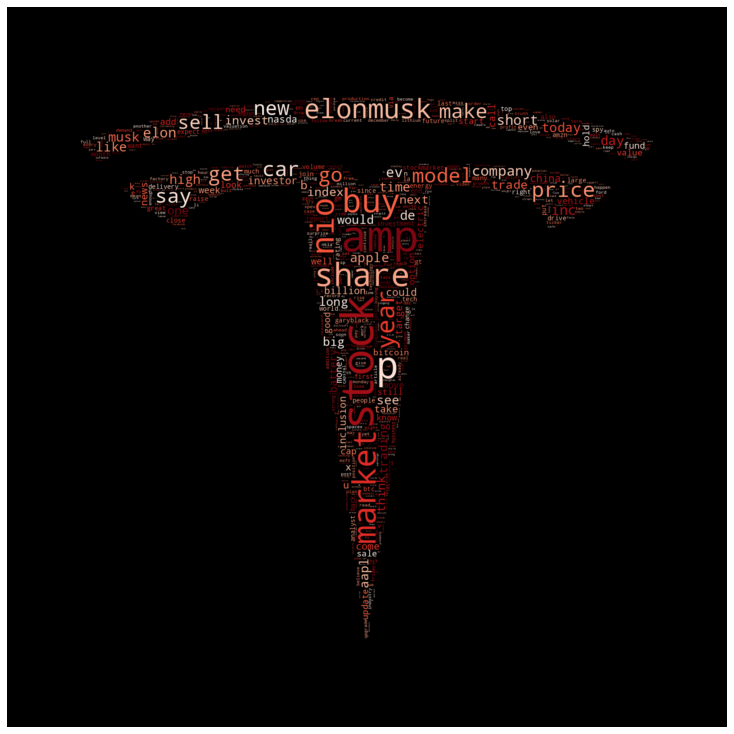

In [88]:
wordcloud = WordCloud(max_words=1000,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Reds',
                      normalize_plurals=True,
                      mask=mask,
                      contour_width=0, 
                      contour_color='red',
                      background_color='black').generate_from_frequencies(freq_dist)
# Extra: you can also add width and height parameters in wordcloud

# Show image and save
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.tight_layout(pad=0) # cut out border
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.savefig('images/tesla_wordcloud.png', dpi=300)
plt.show()